<ipython-input-1-7cc9daf2571c>:28: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  names, varargs, keywords, defaults = inspect.getargspec(func)


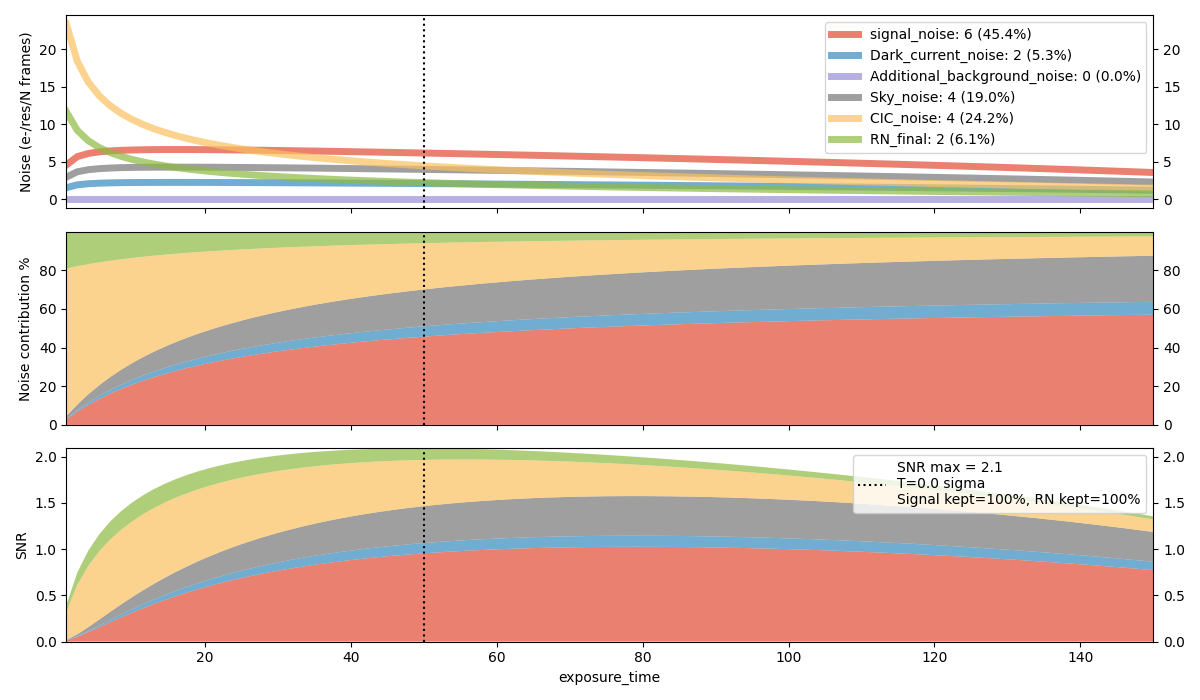

In [1]:
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox
%matplotlib widget
from IPython.display import display, clear_output

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import inspect

import numpy as np
import matplotlib.pyplot as plt
from functools import wraps
import inspect
from scipy.sparse import dia_matrix
# plt.style.use('dark_background')
def initializer(func):
    """
    Automatically assigns the parameters.

    >>> class process:
    ...     @initializer
    ...     def __init__(self, cmd, reachable=False, user='root'):
    ...         pass
    >>> p = process('halt', True)
    >>> p.cmd, p.reachable, p.user
    ('halt', True, 'root')
    """
    names, varargs, keywords, defaults = inspect.getargspec(func)

    @wraps(func)
    def wrapper(self, *args, **kargs):
        for name, arg in list(zip(names[1:], args)) + list(kargs.items()):
            setattr(self, name, arg)

        for name, default in zip(reversed(names), reversed(defaults)):
            if not hasattr(self, name):
                setattr(self, name, default)

        func(self, *args, **kargs)

    return wrapper

#fixed parameters
QE = 0.55
resolution_element=57#microns
pixel_size = 13#microns
Gain_ADU = 0.53 #e-/e-
Throughput = 0.13
Atmosphere = 0.5
colors = ['#E24A33','#348ABD','#988ED5','#777777','#FBC15E','#8EBA42','#FFB5B8']

def variable_smearing_kernels(image, Smearing=1.5, SmearExpDecrement=50000):
    """Creates variable smearing kernels for inversion
    """
    import numpy as np
    
    smearing_length = Smearing * np.exp(-image / SmearExpDecrement)
    smearing_kernels = np.exp(-np.arange(6)[:, np.newaxis, np.newaxis] / smearing_length)
    smearing_kernels /= smearing_kernels.sum(axis=0)
    return smearing_kernels   


class Observation:
    @initializer
    def __init__(self, exposure_time=50, counting_mode=False, Signal=1.25E-17, EM_gain=1400, RN=109, CIC_charge=0.005, Dard_current=0.08, Sky_LU=10000, readout_time=1.5, flight_background_damping = 0.9, Additional_background_2018 = 0,acquisition_time = 2,smearing=0,i=0,plot_=False):#,photon_kept=0.7
        self.ENF = 2 if counting_mode else 1
        self.CIC_noise = np.sqrt(CIC_charge) if counting_mode else np.sqrt(CIC_charge*2)
        self.Dark_current_f = Dard_current * exposure_time / 3600 # e/pix/frame
        self.Dark_current_noise =  np.sqrt(self.Dark_current_f) if counting_mode else np.sqrt(self.Dark_current_f*2)
        
        self.lu2ergs = 2.33E-19/1000        
        self.Sky_ = Sky_LU*self.lu2ergs#/1000*2.33E-19 # ergs/cm2/s/arcsec^2 
        
        if counting_mode:
            #for now we put the regular QE without taking into account the photon fraciton, because then infinite loop
            self.factor_el = QE * Throughput * Atmosphere*(1.1*np.pi/180/3600)**2*np.pi*100**2/4
            self.sky = Sky_LU*self.factor_el*exposure_time  # el/pix/frame
            self.Sky_f =  self.sky * EM_gain * Gain_ADU  # el/pix/frame
            self.Sky_noise_pre_thresholding = np.sqrt(self.sky) if counting_mode else np.sqrt(self.sky*2)
            #self.Signal_LU = Signal / self.lu2ergs# LU(self.Sky_/self.Sky_LU)#ergs/cm2/s/arcsec^2 
            #self.Signal_el = self.Signal_LU*self.factor_el*exposure_time 

            #             self.Photon_count_loss = 0.7 if readout_time==1.5 else 0.8 #a contraindre...
            self.n_threshold, self.Photon_fraction_kept, self.RN_fraction_kept = self.compute_optimal_threshold(plot_=plot_, i=i) #photon_kept
        else:
            self.n_threshold, self.Photon_fraction_kept, self.RN_fraction_kept = 0,1,1

        self.cosmic_ray_loss = np.minimum(0.005*(exposure_time+readout_time/2),1)
        self.QE_efficiency = self.Photon_fraction_kept * QE#* (1-cosmic_ray_loss)#ne devrait pas etre la 
        
        #for now we put the regular QE without taking into account the photon fraciton, because then infinite loop
        self.factor_el = self.QE_efficiency * Throughput * Atmosphere*(1.1*np.pi/180/3600)**2*np.pi*100**2/4
        self.sky = Sky_LU*self.factor_el*exposure_time  # el/pix/frame
        self.Sky_f =  self.sky * EM_gain * Gain_ADU  # el/pix/frame
        self.Sky_noise = np.sqrt(self.sky) if counting_mode else np.sqrt(self.sky*2)
            

        #self.RN_fraction_kept = 0.05 if counting_mode else 1
        self.RN_final = RN  * self.RN_fraction_kept / EM_gain #Are we sure about that? we should a
 

        self.Additional_background = Additional_background_2018 * exposure_time *(1-flight_background_damping) # e/pix/f
        self.Additional_background_noise = np.sqrt(self.Additional_background) if counting_mode else np.sqrt(self.Additional_background*2)




        
        
        self.N_images = acquisition_time*3600/(exposure_time+readout_time)
        coeff_stack = 1 #TBC, why was it set to 2
        self.N_images_true = self.N_images * coeff_stack * (1-self.cosmic_ray_loss)
        self.Total_sky = self.N_images_true * self.sky
        self.sky_resolution = self.Total_sky * (resolution_element/pixel_size)**2# el/N exposure/resol
        self.Signal_LU = Signal / self.lu2ergs# LU(self.Sky_/self.Sky_LU)#ergs/cm2/s/arcsec^2 
        self.Signal_el = self.Signal_LU*self.factor_el*exposure_time  # el/pix/frame#     Signal * (sky / Sky_)  #el/pix
        # print(Signal )
        # print(self.Signal_LU )
        # print(self.Signal_el )
#         if counting_mode:
#             print('%0.1f < ExpTime < %0.1f' %(0.01/self.factor_el/self.Signal_LU,0.1/self.factor_el/self.Signal_LU))
    
        self.Signal_resolution = self.Signal_el *self.N_images_true* (resolution_element/pixel_size)**2# el/N exposure/resol
        self.eresolnframe2lu = self.Signal_LU/self.Signal_resolution
        self.signal_noise = np.sqrt(self.Signal_el) if counting_mode else np.sqrt(self.Signal_el*2)     #el / resol/ N frame
        self.signal_noise_resol = self.signal_noise *resolution_element/pixel_size   # el/resol/frame
        self.signal_noise_nframe = self.signal_noise *np.sqrt(self.N_images_true)  # el/resol/frame
        self.Total_noise_final = np.sqrt(self.signal_noise**2 + self.Dark_current_noise**2  + self.Additional_background_noise**2 + self.Sky_noise**2 + self.CIC_noise**2 + self.RN_final**2   ) #e/  pix/frame
        self.factor = np.sqrt(self.N_images_true) * (resolution_element/pixel_size)
        self.Total_noise_nframe = self.Total_noise_final * np.sqrt(self.N_images_true)
        self.Total_noise_resol = self.Total_noise_nframe * (resolution_element/pixel_size)
        self.SNR = self.Signal_resolution/self.Total_noise_resol
        self.Total_noise_final = self.factor*np.sqrt(self.signal_noise**2 + self.Dark_current_noise**2  + self.Additional_background_noise**2 + self.Sky_noise**2 + self.CIC_noise**2 + self.RN_final**2   ) #e/  pix/frame
        if type(self.Total_noise_final + self.Signal_resolution) == np.float64:#to correct
            n=0
        else:
            n =len(self.Total_noise_final + self.Signal_resolution) 
        if n>1:
            for name in ["signal_noise","Dark_current_noise", "Additional_background_noise","Sky_noise", "CIC_noise", "RN_final","Signal_resolution"]:
                setattr(self, name, getattr(self,name)*np.ones(n))
        self.noises = np.array([self.signal_noise*self.factor,  self.Dark_current_noise*self.factor,  self.Additional_background_noise*self.factor, self.Sky_noise*self.factor, self.CIC_noise*self.factor, self.RN_final*self.factor, self.Signal_resolution]).T

        self.snrs=self.Signal_resolution /self.Total_noise_final
        self.percents =  100* np.array(self.noises).T[:-1,:]**2/self.Total_noise_final**2
        # self.percents =  100* np.array(self.noises).T**2/self.Total_noise_final**2

       

    def PlotNoise(self,title='',x='exposure_time'):
        # plt.style.use('seaborn')
        lw=5
        fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
        for i,(name,c) in enumerate(zip(["signal_noise","Dark_current_noise", "Additional_background_noise","Sky_noise", "CIC_noise", "RN_final"],colors)):
            ax1.plot(getattr(self,x), getattr(self,name)*self.factor,label='%s: %i (%0.1f%%)'%(name,(getattr(self,name)*self.factor)[np.argmax(self.snrs)],self.percents[i,np.argmax(self.snrs)]),lw=lw,alpha=0.7,c=c)
        # ax1.plot(getattr(self,x), getattr(self,"Total_noise_final")*self.factor,label="Total_noise_final", lw=lw,alpha=0.7,c='k')
        ax1.legend(loc='upper right')
        # ax3.plot([getattr(self,x)[np.argmax(self.snrs)],getattr(self,x)[np.argmax(self.snrs)]],[0,np.max(self.snrs)],':',c='k')
        # ax2.plot([getattr(self,x)[np.argmax(self.snrs)],getattr(self,x)[np.argmax(self.snrs)]],[0,100],':',c='k')
        # ax3.plot(getattr(self,x), self.snrs,lw=0,c='k',label='$SNR_{max}$=%0.1f at t=%i'%(np.max(self.snrs),getattr(self,x)[np.argmax(self.snrs)]))
        # ax3.legend(loc='upper right')
        ax1.grid(False)
#         ax1.set_yscale('log')
        ax2.grid(False)
        ax3.grid(False)
        ax3.stackplot(getattr(self,x), self.snrs * np.array(self.noises).T[:-1,:]**2/self.Total_noise_final**2,alpha=0.7,colors=colors)
        ax2.stackplot(getattr(self,x),self.percents,alpha=0.7,colors=colors)
        # stackplot(time,  np.array(self.noises)[:,-1]**2 /np.array(self.noises).T[:1,:]**2)
        ax2.set_xlim((getattr(self,x).min(),getattr(self,x).max()))
        ax2.set_ylim((0,99.99))
        ax3.set_ylim((0,np.max(self.SNR)))
        # ax1.set_ylim((time.min(),time.max()))
        ax3.set_xlabel(x)
        ax3.set_ylabel('SNR')
        ax2.set_ylabel('Noise contribution %')
        ax1.set_ylabel('Noise (e-/res/N frames)')
        ax1.tick_params(labelright=True,right=True)
        ax2.tick_params(labelright=True,right=True)
        ax3.tick_params(labelright=True,right=True)
        # ax1.set_title('$t_{aqu}$:%0.1fh,G$_{EM}$:%i, Counting:%s - SNR$_{MAX}$=%0.1f'%(new.acquisition_time,new.EM_gain,new.counting_mode,np.max(new.SNR)),y=1)
        # fig.suptitle('pompo,')
        # ax1.set_title(title+'Flux:%s, $t_{aqu}$:%0.1fh, G$_{EM}$:%i, Counting:%s'%(self.Signal,self.acquisition_time,self.EM_gain,self.counting_mode))
        fig.tight_layout()
        return fig 

    def compute_optimal_threshold(self,plot_=False,title='',i=0):
        flux = 0.1#self.Signal_el if np.isscalar(self.Signal_el) else 0.3
        Emgain = self.EM_gain if np.isscalar(self.EM_gain) else self.EM_gain[i]#1000
        RN= self.RN if np.isscalar(self.RN) else self.RN[i]#80
        CIC_noise = self.CIC_noise if np.isscalar(self.CIC_noise) else self.CIC_noise[i]
        dark_noise = self.Dark_current_noise if np.isscalar(self.Dark_current_noise) else self.Dark_current_noise[i]
         
        try:
            Sky_noise = self.Sky_noise_pre_thresholding if np.isscalar(self.Sky_noise_pre_thresholding) else self.Sky_noise_pre_thresholding[i]
        except AttributeError:
            raise AttributeError('You must use counting_mode=True to use compute_optimal_threshold method.')

        size= (int(1e3),int(1e3))
        im = np.random.poisson(flux, size=size)
        values,bins = np.histogram(im,bins=[-0.5,0.5,1.5,2.5])
        ConversionGain=1#/4.5
        bins = np.linspace(-500,10000,400)
        #imaADU = (np.random.gamma(im, Emgain) + np.random.normal(0, RN, size=size))*ConversionGain
        imaADU = np.random.gamma(im, Emgain) *ConversionGain
        if plot_:
            fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(9,5))
            val0,_,l0 = ax1.hist(imaADU[im==0],bins=bins,alpha=0.5,log=True,histtype='step',lw=0.5,color='k',label='Before ampl & smearing')
            val1,_,l1 = ax1.hist(imaADU[im==1],bins=bins,alpha=0.5,log=True,histtype='step',lw=0.5,color='k')
            val2,_,l2 = ax1.hist(imaADU[im==2],bins=bins,alpha=0.5,log=True,histtype='step',lw=0.5,color='k')


        if self.smearing > 0:
            # print(SmearExpDecrement)
            smearing_kernels = variable_smearing_kernels(
                imaADU, self.smearing, SmearExpDecrement=5e4
            )
            offsets = np.arange(6)
            A = dia_matrix(
                (smearing_kernels.reshape((6, -1)), offsets),
                shape=(imaADU.size, imaADU.size),
            )

            imaADU = A.dot(imaADU.ravel()).reshape(imaADU.shape)
        # if plot_:
        #    # fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(9,5))
        #     val0,_,l0 = ax1.hist(imaADU[im==0],bins=bins,alpha=0.5,label='Total histogram',log=True,histtype='step',lw=0.5,color='k')
        #     val1,_,l1 = ax1.hist(imaADU[im==1],bins=bins,alpha=0.5,label='Total histogram',log=True,histtype='step',lw=0.5,color='k')
        #     val2,_,l2 = ax1.hist(imaADU[im==2],bins=bins,alpha=0.5,label='Total histogram',log=True,histtype='step',lw=0.5,color='k')


        imaADU += np.random.normal(0, RN, size=size)*ConversionGain
        if plot_:
            val0,_,l0 = ax1.hist(imaADU[im==0],bins=bins,alpha=0.5,label='0',log=True)
            val1,_,l1 = ax1.hist(imaADU[im==1],bins=bins,alpha=0.5,label='1',log=True)
            val2,_,l2 = ax1.hist(imaADU[im==2],bins=bins,alpha=0.5,label='2',log=True)
            ax1.hist(imaADU.flatten(),bins=bins,label='Total histogram',log=True,histtype='step',lw=1,color='k')
        else:
            val0,_ = np.histogram(imaADU[im==0],bins=bins)#,alpha=0.5,label='0',log=True)
            val1,_ = np.histogram(imaADU[im==1],bins=bins)#,alpha=0.5,label='1',log=True)
            val2,_ = np.histogram(imaADU[im==2],bins=bins)#,alpha=0.5,label='2',log=True)

        b = (bins[:-1]+bins[1:])/2
        rn_noise = (RN/(Emgain * ConversionGain)) * np.array([np.sum(val0[b>bi]) for bi in b])/np.sum(val0) #/(Emgain*ConversionGain)#/(Emgain*ConversionGain)
        signal12 = flux * np.array([np.sum(val1[b>bi])+np.sum(val2[b>bi]) for bi in b])/(np.sum(val1)+np.sum(val2))
        signal1 = flux * np.array([np.sum(val1[b>bi]) for bi in b])/np.sum(val1)

        pc =  ([np.sum(val1[b>bi])for bi in b]/(np.array([np.sum(val1[b>bi])for bi in b])+np.array([np.sum(val0[b>bi]) for bi in b])))
       # pc =  ([np.sum(val0[b>bi])for bi in b]/(np.array([np.sum(val1[b>bi])for bi in b])+np.array([np.sum(val0[b>bi]) for bi in b])))


        SNR1 = pc*signal1/np.sqrt(signal1+CIC_noise**2+dark_noise**2+Sky_noise**2+np.array(rn_noise)**2)
        SNR12 = pc*signal12/ np.sqrt(signal12+CIC_noise**2+dark_noise**2+Sky_noise**2+np.array(rn_noise)**2)
        threshold = b[np.nanargmax(SNR1)]
        fraction_signal = np.sum(val1[np.nanargmax(SNR1):])/np.sum(val1)
        fraction_rn = np.sum(val0[np.nanargmax(SNR1):])/np.sum(val0)
        if plot_:
            ax2.plot(b,signal1,label='Signal(Signal>T)')
            ax2.plot(b,np.array(rn_noise)**2,label='(RN(RN>T)/EMGAIN)**2')
            ax2.plot(b,pc,label='Fraction(T) of true positive')
            #ax2.plot(b,SNR1/pc,label='SNR without fraction')



            ax2.plot(b,SNR1,label='SNR, frac(N0)=%i%%, frac(N1)=%i%%'%(100*np.sum(val0[np.nanargmax(SNR1):])/np.sum(val0),100*np.sum(val1[np.nanargmax(SNR1):])/np.sum(val1)))

            # ax2.plot(b,SNR1,label='[N1]/[N0] = %0.2f, frac(N1)=%i%%'%(val1[np.nanargmax(SNR1)]/val0[np.nanargmax(SNR1)],100*np.sum(val1[np.nanargmax(SNR1):])/np.sum(val1)))
            # ax2.plot(b,SNR12,label='[N1+N2]/[N0] = %0.2f, frac(N1+N2)=%i%%'%((val1[np.nanargmax(SNR12)]+val2[np.nanargmax(SNR12)])/val0[np.nanargmax(SNR12)],100*np.sum(val1[np.nanargmax(SNR12):]+val2[np.nanargmax(SNR12):])/(np.sum(val1)+np.sum(val2))))

            L = ax1.legend()
            ax2.legend()
            ax2.set_xlabel('ADU')
            ax1.set_ylabel('#')
            ax2.set_ylabel('SNR')
            threshold = b[np.nanargmax(SNR1)]
            L.get_texts()[1].set_text('0 e- : %i%%, faction kept: %0.2f%%'%(100*values[0]/(size[0]*size[1]),100*np.sum(val0[np.nanargmax(SNR1):])/np.sum(val0)))
            L.get_texts()[2].set_text('1 e- : %i%%, faction kept: %0.2f%%'%(100*values[1]/(size[0]*size[1]),100*np.sum(val1[np.nanargmax(SNR1):])/np.sum(val1)))
            L.get_texts()[3].set_text('2 e- : %i%%, faction kept: %0.2f%%'%(100*values[2]/(size[0]*size[1]),100*np.sum(val2[np.nanargmax(SNR1):])/np.sum(val2)))
            ax1.plot([threshold,threshold],[0,np.max(val0)],':',c='k')
            ax2.plot([threshold,threshold],[0,np.nanmax(SNR1)],':',c='k')
            ax1.set_title(title+'Gain = %i, RN = %i, flux = %0.2f, Smearing=%0.1f, Threshold = %i = %0.2f$\sigma$'%(Emgain,RN,flux,self.smearing, threshold,threshold/(RN*ConversionGain)))
            ax1.set_xlim(xmin=bins.min(),xmax=7000)
            fig.tight_layout()

        #print(i)
        #print('flux, threshold,fractions = ',flux,threshold, fraction_signal, fraction_rn)
        #print('RN, Sky_noise, Emgain, CIC_noise: ', RN, Sky_noise, Emgain, CIC_noise)
        return threshold/(RN*ConversionGain), fraction_signal, fraction_rn
 



    

np.seterr(invalid='ignore')
class ExposureTimeCalulator(widgets.HBox):
     
    def __init__(self, exposure_time=50, acquisition_time=2, Sky_LU=4, Signal=5.57e-18, EM_gain=1400,RN=109,CIC_charge=0.005, Dard_current=0.08,readout_time=1.5,x_axis='exposure_time',counting_mode=False,smearing=0.7,Additional_background_2018=0):
        super().__init__()
        self.output = widgets.Output()
        self.Additional_background_2018=Additional_background_2018
        Nominal = Observation(exposure_time=np.linspace(1,150,100),counting_mode=counting_mode, Signal=Signal, EM_gain=EM_gain, RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, Sky_LU=10**Sky_LU, readout_time=readout_time, acquisition_time = acquisition_time,Additional_background_2018=self.Additional_background_2018,smearing=smearing)#,photon_kept=photon_kept
        #flight_background_damping = 0.9, Additional_background_2018 = 0.0007
        self.x = Nominal.exposure_time#np.linspace(0, 2 * np.pi, 100)
        self.fig  = Nominal.PlotNoise()
        args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
        self.v=[]
        for i, ax in enumerate(self.fig.axes):
            if i==2:
                
                label = 'SNR max = %0.1f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%i%%'%(Nominal.SNR.max(),Nominal.n_threshold, 100*Nominal.Photon_fraction_kept, 100*Nominal.RN_fraction_kept)
                self.v.append(ax.axvline(locals_[x_axis],ls=':',c='k',label=label))
            else:
                self.v.append(ax.axvline(locals_[x_axis],ls=':',c='k'))
        ax.legend(loc='upper right')
        self.ax0 =  self.fig.axes[0]
        self.ax1 =  self.fig.axes[1]
        self.ax2 =  self.fig.axes[2]
    
        self.fig.canvas.toolbar_position = 'bottom'
        style={}#{'description_width': 'initial'} 
        width = '400px'
        self.exposure_time = widgets.IntSlider( min=1, max=150,value=exposure_time, layout=Layout(width=width),description='Texp (s)')#'$t_{exp}$ (s)')
        self.acquisition_time = widgets.FloatSlider( min=0.1, max=10,value=acquisition_time, layout=Layout(width=width),description='Taq (h)')#'$t_{aq}$ (h)')
        self.Sky_LU = widgets.FloatLogSlider( min=4, max=7,value=Sky_LU,base=10, style =style, layout=Layout(width=width),description='Sky (LU)')
#         self.Signal = widgets. FloatLogSlider( min=-18, max=-15,value=1.25e-17, base=10,step=1e-18, style = style, layout=Layout(width='500px'),description='Flux')
        self.Signal = widgets.Dropdown(options=[('Bright Galex star (mU~15)', 2.22e-14), ('Extremely Bright QSO (mU~15)', 5.08e-15), ('Bright QSO (mU~19.5)', 3.51e-16),('Bright galaxy (mU~22.5)', 2.22e-17), ('Regular galaxy (mU~24)', 5.57e-18), ('Low SB galaxy (mU~25)', 2.2e-18)],value=Signal,description='Flux')
        self.EM_gain = widgets.IntSlider( min=200, max=2000,value=EM_gain, style = style, layout=Layout(width=width),description='EM gain')
        self.RN = widgets.IntSlider( min=30, max=120,value=RN, style = style, layout=Layout(width=width),description='Read noise')
        self.CIC_charge = widgets.FloatSlider( min=0.003, max=0.05,value=CIC_charge,style = style, layout=Layout(width=width),description='CIC charge',step=0.001,readout_format='.3f')#$_{charge}$
        self.Dard_current = widgets.FloatSlider( min=0.01, max=0.2,value=Dard_current, style = style, layout=Layout(width=width),description='Dard current',step=0.0011,readout_format='.2f')#$_{current}$
        self.readout_time = widgets.FloatSlider( min=1.5, max=20,value=readout_time, style = style, layout=Layout(width=width),description=r'RO time (s)',step=0.1)#$_{time}$
        self.x_axis=widgets.Dropdown(options=['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","CIC_charge","Dard_current" ,"readout_time"],value=x_axis,description='X axis')#,"smearing"
#         self.mode=widgets.Dropdown(options=['Flight 2018','Nominal 2022 10MHz','Nominal 2022 100MHz'],value='Nominal 2022 10MHz',description='X axis')
        self.counting_mode = widgets.Checkbox(value=counting_mode,description='Thresholding photon counting',disabled=False)#,indent=False)
        # smearing = widgets.FloatSlider( min=0, max=1.5,value=0.7, layout=Layout(width='500px'),description='CTE not yet',step=0.001)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')

        self.smearing = widgets.FloatSlider( min=0, max=2,value=smearing, layout=Layout(width=width),description='Smearing',step=0.01)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')      
        self.smearing.layout.visibility = 'hidden'
    


        
        # wids = widgets.interact(self.update,x_axis=x_axis,counting_mode=False,exposure_time=exposure_time,Sky_LU=Sky_LU,acquisition_time=acquisition_time,Signal=Signal,EM_gain=EM_gain,RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, readout_time=readout_time)
        wids = widgets.interactive(self.update,x_axis=self.x_axis,smearing=self.smearing,counting_mode=self.counting_mode,exposure_time=self.exposure_time,Sky_LU=self.Sky_LU,acquisition_time=self.acquisition_time,Signal=self.Signal,EM_gain=self.EM_gain,RN=self.RN, CIC_charge=self.CIC_charge, Dard_current=self.Dard_current, readout_time=self.readout_time)
        controls = VBox([HBox([self.x_axis,self.Signal,self.counting_mode]),   HBox([self.Sky_LU,self.EM_gain,self.smearing])     ,  HBox([self.acquisition_time,self.Dard_current,self.CIC_charge]),    HBox([self.exposure_time,self.RN,self.readout_time]) ] )
        display(HBox([self.output,controls]))


        


    def update(self, x_axis,counting_mode,Sky_LU,acquisition_time,Signal,EM_gain,RN,CIC_charge,Dard_current,readout_time,exposure_time,smearing):
        """Draw line in plot"""
        with self.output:
            args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
#             self.fig.suptitle('pompo,')
            self.ax0.set_title('Gain=%i, Texp=%i, CIC=%0.3f, Dark=%0.3f, RN=%i, Signal=%0.2E, Sky=%0.2E'%(EM_gain,exposure_time,CIC_charge,Dard_current,RN,Signal,Sky_LU),y=0.97)
            value = locals_[x_axis]
            if x_axis == 'exposure_time':
                exposure_time=np.linspace(1,150,100)
            if x_axis == 'Sky_LU':
                Sky_LU=np.logspace(3,7,100)
                
            if x_axis == 'exposure_time':
                exposure_time=np.linspace(1,150)
            if x_axis == 'Signal':
                Signal=np.logspace(-18,-15)
            if x_axis == 'EM_gain':
                EM_gain=np.linspace(200,2000)
            if x_axis == 'acquisition_time':
                acquisition_time=np.linspace(0.1,6)
            if x_axis == 'RN':
                RN=np.linspace(30,120,100)
            elif x_axis == 'CIC_charge':
                CIC_charge=np.linspace( 0.003, 0.05)
            if x_axis == 'Dard_current':
                Dard_current=np.linspace(0.01,0.2)
            if x_axis == 'readout_time':
                readout_time=np.linspace(0, 50)
            if x_axis == 'smearing':
                readout_time=np.linspace(0, 2)

            if (x_axis == 'Sky_LU') | (x_axis == 'Signal'):
                self.ax0.set_xscale('log')
#                 self.ax2.set_yscale('log')
            else:
                self.ax0.set_xscale('linear')
#                 self.ax2.set_yscale('linear')
            if counting_mode:
                self.smearing.layout.visibility = 'visible'
            else:
                self.smearing.layout.visibility = 'hidden'
            args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
            new_value = locals_[x_axis]
            arg = np.argmin(abs(new_value - value))
            #print('argi = ',value,new_value,arg)
            new = Observation(exposure_time=exposure_time,Sky_LU=Sky_LU, acquisition_time=acquisition_time,counting_mode=counting_mode,Signal=Signal,EM_gain=EM_gain,RN=RN,CIC_charge=CIC_charge,Dard_current=Dard_current,readout_time=readout_time,smearing=smearing,Additional_background_2018=self.Additional_background_2018,i=arg)
            for v in self.v:
                v.set_xdata([value,value])
            # arg = np.argmin(abs(getattr(new,x_axis) - value))
            # print('arg = ',arg)
            label = 'SNRmax=%0.2f, SNR=%0.2f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%i%%'%(new.SNR.max(),new.SNR[arg],new.n_threshold, 100*new.Photon_fraction_kept, 100*new.RN_fraction_kept)
            self.v[-1].set_label(label)

            # self.v[-1].set_label('SNRmax=%0.2f, SNR=%0.2f'%(new.SNR.max(),new.SNR[arg]))
            max_,min_=[],[]
            for i,name in enumerate(["signal_noise","Dark_current_noise", "Additional_background_noise","Sky_noise", "CIC_noise", "RN_final"]):
                self.fig.axes[0].lines[i].set_xdata(getattr(new,x_axis))
                self.fig.axes[0].lines[i].set_ydata(getattr(new,name)*new.factor)
                max_.append(np.nanmax(getattr(new,name)*new.factor))
                min_.append(np.nanmin(getattr(new,name)*new.factor))
                self.fig.axes[0].lines[i].set_label('%s: %i (%0.1f%%)'%(name,(getattr(new,name)*new.factor)[np.argmax(new.snrs)],new.percents[i,np.argmax(new.snrs)]))
            self.ax0.set_ylim((-0.5,np.max(max_)))
            self.ax2.legend(loc='upper right')
            self.fig.axes[0].legend(loc='upper right')
            self.fig.axes[1].collections.clear()#cla()#
            self.fig.axes[1].stackplot(getattr(new,x_axis),new.percents,alpha=0.7,colors=colors)
            self.fig.axes[2].collections.clear()#cla()#
            self.fig.axes[2].stackplot(getattr(new,x_axis),new.snrs * np.array(new.noises).T[:-1,:]**2/new.Total_noise_final**2,alpha=0.7,colors=colors)
            # self.fig.axes[0].lines[0].set_ydata(new.SNR)
            # self.fig.axes[2].lines[0].set_ydata(new.SNR)
            # self.line.set_xdata(getattr(new,x_axis))
            # self.line.set_ydata(new.SNR)
            # self.line.set_data(getattr(new,x_axis),new.SNR)
            self.ax2.set_xlabel(x_axis)
            # self.fig.suptitle('$t_{aqu}$:%0.1fh,G$_{EM}$:%i, Counting:%s - SNR$_{MAX}$=%0.1f'%(new.acquisition_time,new.EM_gain,new.counting_mode,np.max(new.SNR)),y=1)
            # self.fig.axes[0].set_title('$t_{aqu}$:%0.1fh,G$_{EM}$:%i, Counting:%s - SNR$_{MAX}$=%0.1f'%(new.acquisition_time,new.EM_gain,new.counting_mode,np.max(new.SNR)),y=1)
            # self.ax2.set_ylim((np.min(new.SNR),1.1*np.max(new.SNR)))
            self.ax2.set_xlim((np.min(getattr(new,x_axis)),np.max(getattr(new,x_axis))))
            self.ax2.set_ylim((0,np.max(getattr(new,'SNR'))))


            
#Nominal = Observation(exposure_time=np.array([50,50]),EM_gain=1000, RN=100,smearing=0.8).compute_optimal_threshold(plot_=True)#1.5)#2022
#Nominal = Observation(exposure_time=np.array([50,50]),EM_gain=1000, RN=50,smearing=0.8).compute_optimal_threshold(plot_=True)#1.5)#2022
ETC = ExposureTimeCalulator(EM_gain=1000,RN=50, smearing=0.8,x_axis='exposure_time',counting_mode=False)




In [2]:

def PlotFit1D(
    x=None,
    y=[709, 1206, 1330],
    deg=1,
    plot_=True,
    sigma_clip=None,
    title=None,
    xlabel=None,
    ylabel=None,
    P0=None,
    bounds=(-1e10, 1e10),
    fmt=".",
    ax=None,
    # c="black",
    Type="normal",
    sigma=None,
    # ls=":",
    interactive=False,
    **kwargs,
):
    """ PlotFit1D(np.arange(100),np.arange(100)**2
    + 1000*np.random.poisson(1,size=100),2)
    """
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from decimal import Decimal
    import numpy as np

    x, y = np.array(x), np.array(y)

    if x is None:
        x = np.arange(len(y))

    if sigma is not None:
        x = x[np.isfinite(y)]
        y = y[np.isfinite(y)]
        sigma = sigma[np.isfinite(y)]
    else:
        x = x[np.isfinite(y)]
        y = y[np.isfinite(y)]

    x = np.array(x)
    y = np.array(y)

    if sigma_clip is not None:
        index = (
            (x > np.nanmean(x) - sigma_clip[0] * np.nanstd(x))
            & (x < np.nanmean(x) + sigma_clip[0] * np.nanstd(x))
            & (y > np.nanmean(y) - sigma_clip[1] * np.nanstd(y))
            & (y < np.nanmean(y) + sigma_clip[1] * np.nanstd(y))
        )
        x, y = x[index], y[index]
        std = np.nanstd(y)
    else:

        sigma_clip = [10, 1]
        index = (
            (x > np.nanmean(x) - sigma_clip[0] * np.nanstd(x))
            & (x < np.nanmean(x) + sigma_clip[0] * np.nanstd(x))
            & (y > np.nanmean(y) - sigma_clip[1] * np.nanstd(y))
            & (y < np.nanmean(y) + sigma_clip[1] * np.nanstd(y))
        )
        std = np.nanstd(y[index])

    if plot_ & (ax is None):
        fig = plt.figure()  # figsize=(10,6))
        gs = gridspec.GridSpec(2, 1, height_ratios=(4, 1))
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
        if sigma is None:
            ax1.plot(x, y, fmt, label="Data", **kwargs)
        else:
            ax1.errorbar(x, y, fmt=fmt, yerr=sigma, **kwargs)

    xp = np.linspace(x.min(), x.max(), 1000)

    def linear_func(p, x):
        m, c = p
        return m * x + c

    if type(deg) == int:
        z, res, rank, singular, rcond = np.polyfit(x, y, deg, full=True)
        pcov = None
        popt = np.poly1d(z)
        law = np.poly1d(z)
        if (deg == 1) & (Type == "ortho"):
            import scipy

            linear_model = scipy.odr.Model(linear_func)
            data = scipy.odr.RealData(x, y)
            odr = scipy.odr.ODR(data, linear_model, beta0=[0.0, 1.0])
            out = odr.run()
            popt = np.poly1d(out.beta)
            law = np.poly1d(out.beta)
        zp = popt(xp)
        if P0 is not None:
            z0 = np.poly1d(P0)(xp)
        zz = popt(x)
        degs = [" %0.2f * x^%i" % (a, i) for i, a in enumerate(popt.coef[::-1])]
        # name = "Fit: " + "+".join(degs) + ", R=%0.2E" % (Decimal(res[0]))
    else:
        from scipy.optimize import curve_fit

        if deg == "exp":

            def law(x, b, a, offset):
                return b * np.exp(-x / a) + offset

            if P0 is None:
                P0 = [np.nanmax(y) - np.nanmin(y), 1, np.nanmin(y)]
        if deg == "2exp":
            law = (
                lambda x, b1, b2, a1, a2, offset: b1 * np.exp(-x / a1)
                + b2 * np.exp(-x / a2)
                + offset
            )
        elif deg == "gaus":
            law = (
                lambda x, a, xo, sigma, offset: a ** 2
                * np.exp(-np.square((x - xo) / sigma) / 2)
                + offset
            )
            if P0 is None:
                P0 = [
                    np.nanmax(y) - np.nanmin(y),
                    x[np.argmax(y)],
                    np.std(y),
                    np.nanmin(y),
                ]
        elif deg == "power":

            def law(x, amp, index, offset):
                return amp * (x ** index) + offset

            P0 = None
        elif callable(deg):
            law = deg
        if P0 is not None:
            z0 = law(xp, *P0)

        if interactive:
            print("Interactive Fit")
            from IPython import get_ipython

            get_ipython().run_line_magic("matplotlib", "")
            if len(P0) == 1:
                interactiv_manual_fitting(
                    x,
                    y,
                    initial="%s(x,a*%f)" % (law.__name__, *P0,),
                    dict_={law.__name__: law},
                )
            if len(P0) == 2:
                print("Interactive Fit")
                interactiv_manual_fitting(
                    x,
                    y,
                    initial="%s(x,a*%f,b*%f)" % (law.__name__, *P0,),
                    dict_={law.__name__: law},
                )
            if len(P0) == 3:
                interactiv_manual_fitting(
                    x,
                    y,
                    initial="%s(x,a*%f,b*%f,c*%f)" % (law.__name__, *P0,),
                    dict_={law.__name__: law},
                )
            if len(P0) == 4:
                interactiv_manual_fitting(
                    x,
                    y,
                    initial="%s(x,a*%f,b*%f,c*%f,d*%f)" % (law.__name__, *P0,),
                    dict_={law.__name__: law},
                )
            plt.show()
            get_ipython().run_line_magic("matplotlib", "inline")
            return {
                "popt": np.zeros(len(P0)),
                "pcov": np.zeros((len(P0), len(P0))),
                "res": 0,
                "y": y,
                "x": x,
                "curve": [],
            }
        try:
            popt, pcov = curve_fit(law, x, y, p0=P0, bounds=bounds, sigma=sigma)
        except RuntimeError as e:
            # print(law)
            # print(type(law))
            # print(e)
            if interactive:
                if input("Do you want to fit it manually? [y/n]") == "y":
                    from IPython import get_ipython

                    get_ipython().run_line_magic("matplotlib", "")
                    if len(P0) == 1:
                        interactiv_manual_fitting(
                            x,
                            y,
                            initial="%s(x,a*%f)" % (law.__name__, *P0,),
                            dict_={law.__name__: law},
                        )
                    if len(P0) == 2:
                        interactiv_manual_fitting(
                            x,
                            y,
                            initial="%s(x,a*%f,b*%f)" % (law.__name__, *P0,),
                            dict_={law.__name__: law},
                        )
                    if len(P0) == 3:
                        interactiv_manual_fitting(
                            x,
                            y,
                            initial="%s(x,a*%f,b*%f,c*%f)" % (law.__name__, *P0,),
                            dict_={law.__name__: law},
                        )
                    if len(P0) == 4:
                        interactiv_manual_fitting(
                            x,
                            y,
                            initial="%s(x,a*%f,b*%f,c*%f,d*%f)" % (law.__name__, *P0,),
                            dict_={law.__name__: law},
                        )
                    get_ipython().run_line_magic("matplotlib", "inline")
                    return {
                        "popt": np.zeros(len(P0)),
                        "pcov": np.zeros((len(P0), len(P0))),
                        "res": 0,
                        "y": y,
                        "x": x,
                        "curve": [],
                    }
            else:
                return {
                    "popt": np.zeros(len(P0)),
                    "pcov": np.zeros((len(P0), len(P0))),
                    "res": 0,
                    "y": y,
                    "x": x,
                    "curve": [],
                }
        res = -99
        res = np.sum(np.square(y - law(x, *popt)))
        zp = law(xp, *popt)
        zz = law(x, *popt)
        name = "Fit %s, R=%0.2E" % (
            np.round(np.array(popt, dtype=int), 0),
            Decimal(res),
        )
    if plot_:
        if ax is None:
            # if deg == "gaus":
            # ax1.text(
            #     popt[1], popt[0] ** 2, "Max = %0.1f std" % (popt[0] ** 2 / std),
            # )
            if title:
                fig.suptitle(title, y=1)
            if xlabel:
                ax2.set_xlabel(xlabel)
            if ylabel:
                ax1.set_ylabel(ylabel)
            ax1.tick_params(
                axis="x", which="both", bottom=False, top=False, labelbottom=False,
            )
            ax2.set_ylabel("Error")
            line = ax1.plot(xp, zp, **kwargs)
            # if P0 is not None:
            #     ax1.plot(xp, z0, ":")
            ax2.plot(x, y - zz, fmt, **kwargs)
            ax2.set_xlim(ax1.get_xlim())
            ax2.plot([-1e100, 1e100], [0, 0], **kwargs)
            ax1.grid(linestyle="dotted")
            ax2.grid(linestyle="dotted")
            ax1.legend()
            plt.tight_layout()
        else:
            xp = np.linspace(
                np.nanmin(xp) - 2 * xp.ptp(), np.nanmax(xp) + 2 * xp.ptp(), 5 * len(xp),
            )
            try:
                line = ax.plot(xp, np.poly1d(z)(xp), **kwargs)
            except UnboundLocalError:
                line = ax.plot(xp, law(xp, *popt), **kwargs)
            ax1, ax2 = ax, ax
        return {
            "popt": popt,
            "pcov": pcov,
            "res": res,
            "axes": [ax1, ax2],
            "y": y,
            "x": x,
            "curve": line,
            "sigma": sigma,
            "y_fit": zz,
            "function": law,
        }
    else:
        return {
            "popt": popt,
            "pcov": pcov,
            "res": res,
            "y": y,
            "x": x,
            "curve": [],
            "sigma": sigma,
            "y_fit": zz,
            "function": law,
        }
    return {
        "popt": popt,
        "pcov": pcov,
        "res": res,
        "y": y,
        "x": x,
        "curve": [],
        "sigma": sigma,
        "y_fit": zz,
        "function": law,
    }



In [3]:
from scipy.sparse import dia_matrix
from astropy.table import Table
import glob



def EMCCDhist(
    x,
    bias=[1e3, 4.5e3, 1194],
    RN=[0, 200, 53],
    EmGain=[100, 10000, 5000],
    flux=[0.001, 1, 0.04],
    smearing=[0, 1, 0.01],
    sCIC=[0, 1, 0],
    n_pix = 10**6.3,

):
    # def EMCCDhist(x, bias=[1e3, 4.5e3,1194], RN=[0,200,53], EmGain=[100, 10000,5000], flux=[0.001, 1,0.04], smearing=[0, 3,0.31], sCIC=[0,1,0],SmearExpDecrement=[1.5e3,1.5e5,15e4]):
    from scipy.sparse import dia_matrix
    import inspect
    from astropy.table import Table
    from matplotlib.widgets import Button
    import numpy as np

    if bias > 1500:
        ConversionGain = 0.53  # 1/4.5 #ADU/e-  0.53 in 2018
    else:
        ConversionGain = 1 / 4.5  # ADU/e-  0.53 in 2018

    # def variable_smearing_kernels(image, Smearing=1.5, SmearExpDecrement=50000):
    #     """Creates variable smearing kernels for inversion
    #     """
    #     import numpy as np
    #     n=6
    #     smearing_length = Smearing * np.exp(-image / SmearExpDecrement)
    #     smearing_kernels = np.exp(-np.arange(n)[:, np.newaxis, np.newaxis] / smearing_length)
    #     smearing_kernels /= smearing_kernels.sum(axis=0)
    #     return smearing_kernels
    def variable_smearing_kernels(
        image, Smearing=0.7, SmearExpDecrement=50000, type_="exp"
    ):
        """Creates variable smearing kernels for inversion
        """
        import numpy as np

        n = 15
        smearing_length = Smearing * np.exp(-image / SmearExpDecrement)
        if type_ == "exp":
            smearing_kernels = np.exp(
                -np.arange(n)[:, np.newaxis, np.newaxis] / smearing_length
            )
        else:
            assert 0 <= Smearing <= 1
            smearing_kernels = np.power(Smearing, np.arange(n))[
                :, np.newaxis, np.newaxis
            ] / np.ones(smearing_length.shape)
        smearing_kernels /= smearing_kernels.sum(axis=0)
        return smearing_kernels

    def simulate_fireball_emccd_hist(
        x,
        ConversionGain,
        EmGain,
        Bias,
        RN,
        Smearing,
        SmearExpDecrement,
        n_registers,
        flux,
        sCIC=0,
        n_pix = n_pix,
    ):
        """Silumate EMCCD histogram
        """
        import numpy as np

        # try:
        #     y = globals()["y"]
        #     # print('len y=',len(y))
        #     # print(' y=',y[y>1])
        #     # print('sum',np.nansum(y[np.isfinite(y)]))
        #     n_pix = np.nansum(10 ** y[np.isfinite(10 ** y)])  # 1e6#
        #     # print("global", np.sum(10 ** y), n_pix)
        # except TypeError:
        #     n_pix = 10 ** 6.3
        #     # print("fixed", np.sum(10 ** y), n_pix)
        n = 1
        # print('npix', n_pix)
        im = np.zeros(int(n_pix))  #
        im = np.zeros((1000, int(n_pix / 1000)))
        # im = np.zeros((1000,10+1))
        # factor = 1#np.log(2)
        # EmGain *= factor
        # imaADU = np.random.gamma(flux, EmGain, size=im.shape)
        # print(np.max([flux,0]),flux,EmGain)
        imaADU = np.random.gamma(
            np.random.poisson(np.nanmax([flux, 0]), size=im.shape), abs(EmGain)
        )
        # Add pCIC (no interest, as flux)
        # imaADU[np.random.rand(size[1],size[0]) <  p_pCIC] += 1

        # pixels in which sCIC electron might appear
        p_sCIC = sCIC / np.mean(
            1 / np.power(EmGain * ConversionGain, np.arange(604) / 604)
        )
        # / np.mean(1 / np.power(EmGain * ConversionGain, np.arange(604) / 604))

        id_scic = (
            np.random.rand(im.shape[0], im.shape[1])
            < p_sCIC
            # np.random.rand(im.shape[0])< p_sCIC
        )  # sCIC  # sCIC positions
        # stage of the EM register at which each sCIC e- appear
        register = np.random.randint(1, n_registers, size=id_scic.sum())
        # Compute and add the partial amplification for each sCIC pixel
        imaADU[id_scic] += np.random.exponential(
            np.power(EmGain, register / n_registers)
        )
        imaADU *= ConversionGain

        if Smearing > 0:
            smearing_kernels = variable_smearing_kernels(
                imaADU, Smearing, SmearExpDecrement
            )
            offsets = np.arange(6)
            A = dia_matrix(
                (smearing_kernels.reshape((6, -1)), offsets),
                shape=(imaADU.size, imaADU.size),
            )
            imaADU = A.dot(imaADU.ravel()).reshape(imaADU.shape)
        read_noise = np.random.normal(0, RN * ConversionGain, size=im.shape)
        imaADU += Bias
        imaADU += read_noise
        range = [np.nanmin(x), np.nanmax(x)]
        # n, bins = np.histogram(imaADU.flatten(), range=range, bins=len(x))
        # print(x)
        n, bins = np.histogram(imaADU.flatten(), bins=[x[0] - 1] + list(x))
        n_conv = 1
        return np.convolve(n, np.ones(n_conv) / n_conv, mode="same")

    y = simulate_fireball_emccd_hist(
        x=x,
        ConversionGain=ConversionGain,  # 0.53,
        EmGain=EmGain,
        Bias=bias,
        RN=RN,
        Smearing=smearing,
        SmearExpDecrement=1e4,  # 1e4,  # 1e5 #2022=1e5, 2018=1e4...
        n_registers=604,
        flux=flux,
        sCIC=sCIC,
    )
    y[y == 0] = 1
    y /= x[1] - x[0]
    # print("len(y)", np.sum(y))
    return np.log10(y)



In [4]:
def Fit_hist(bins,val,val_os):
    bins_os=bins
    os_v = val_os
    bias = bins_os[np.nanargmax(val_os)] + 0.5  #  #ADDED xdata[np.nanargmax(ydata)]
    if bias > 1500:
        conversion_gain = 0.53  
        smearing = 1.5 
        RN = 60 
    else:
        conversion_gain = 1 / 4.5 
        smearing = 0.7  
        RN = 10
    # mask_RN_os = (bins > bias - 1 * RN) & (bins < bias + 0.8 * RN) & (val_os > 0)
    mask_RN_os = (bins > bias - 1 * RN/conversion_gain) & (bins < bias + 0.8 * RN/conversion_gain) & (val_os > 0)
    RON = np.abs(
        PlotFit1D(
            bins[mask_RN_os],
            val_os[mask_RN_os],
            deg="gaus",
            plot_=False,
            P0=[1, bias, RN, 0],
        )["popt"][2]
        / conversion_gain
    )
    function = lambda x, Bias, RN, EmGain, flux, smearing, sCIC: EMCCDhist(
        x, bias=Bias, RN=RN, EmGain=EmGain, flux=flux, smearing=smearing, sCIC=sCIC
    )

    try:
        upper_limit = bins[
            np.where(
                (bins > bias)
                & (
                    np.convolve(val, np.ones(1), mode="same")
                    == np.nanmin(val)
                )
            )[0][0]
        ]
    except (ValueError, IndexError) as e:
        upper_limit = np.max(bins)

    try:
        upper_limit_os = bins[
            np.where(
                (bins_os[np.isfinite(os_v)] > bias)
                & (
                    np.convolve(os_v[np.isfinite(os_v)], np.ones(1), mode="same")
                    == np.nanmin(os_v.min)
                )
            )[0][0]
        ]
    except (ValueError, IndexError) as e:
        upper_limit_os = np.max(bins_os)
    mask_gain1 = (bins > bias + 4 * RON) & (bins < upper_limit)
    try:
        gain = (
            -1
            / np.log(10)
            / conversion_gain
            / PlotFit1D(bins[mask_gain1], np.log10(val[mask_gain1]), deg=1, plot_=False,)[
                "popt"
            ][1]
        )
    except ValueError:
        gain = 1200
    flux = np.nanmax([0.01]+ [(np.average(bins, weights=val) - np.average(bins, weights=val_os))/ (gain * conversion_gain)])
    return bias, RON, gain, flux, smearing, 0.005
# _=Fit_hist(x,y,a['col2'])

HistogramFitter()

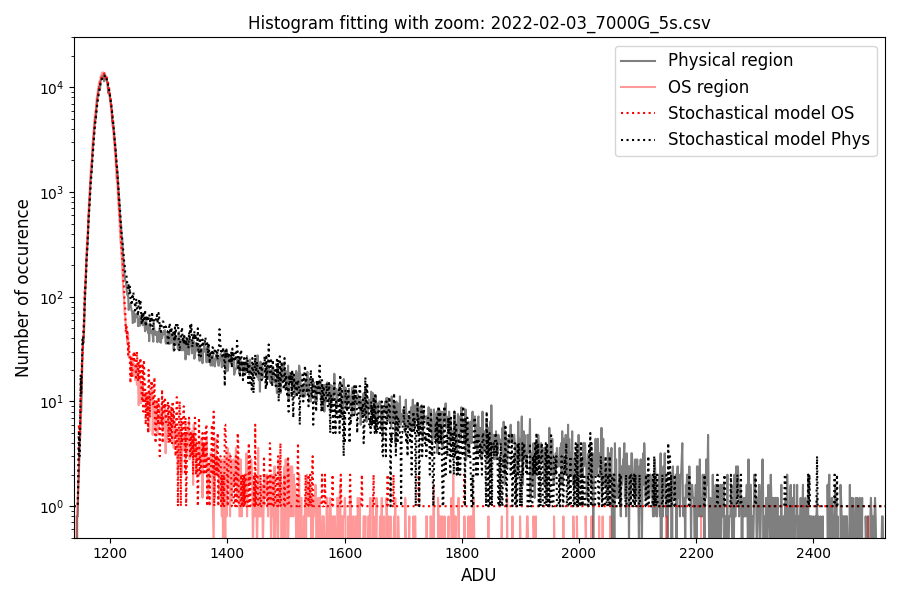

In [5]:


class HistogramFitter(widgets.HBox):
    def __init__(self, ):
        super().__init__()
        self.output = widgets.Output()
        self.pre_path = 'histograms/Histogram_'
        files = glob.glob(self.pre_path+'*.csv')
        files.sort()
        options = [file.replace(self.pre_path,'') for file in files][::-1]
        path = options[0]
        self.file = self.pre_path+path
        a = Table.read(self.file)
        self.x=a['col0'] #- a['col0'].min()
        self.y=a['col1']
        self.y_os=a['col2']
        self.n_pix = np.nansum( self.y[np.isfinite(self.y)]) # # 1e6#

        bias, RN, emgain, flux, smearing, sCIC = Fit_hist(self.x,self.y,self.y_os)
        # print(bias, RN, emgain, flux, smearing, sCIC)
        self.fig, self.ax = plt.subplots(figsize=(9,6))
        self.ax.semilogy(self.x,self.y,c='k',alpha=0.5,label='Physical region')
        self.ax.semilogy(self.x,self.y_os,c='r',alpha=0.4,label='OS region')
        # anal1=ax.semilogy(x,10**EMCCD(x, bias=1200, RN=RN, EmGain=emgain, flux=flux, smearing=smearing1, sCIC=sCIC),c='b',label='Analytical model')
        stoch1=self.ax.semilogy(self.x,10**EMCCDhist(self.x, bias=bias, RN=RN, EmGain=emgain, flux=0, smearing=smearing, sCIC=sCIC,n_pix=self.n_pix),':',c='r',label='Stochastical model OS')
        # print('f,',flux)
        # anal2=ax.semilogy(x,10**EMCCD(x, bias=1200, RN=RN, EmGain=emgain, flux=flux, smearing=smearing2, sCIC=sCIC),c='k',label='Analytical model')
        stoch2=self.ax.semilogy(self.x,10**EMCCDhist(self.x, bias=bias, RN=RN, EmGain=emgain, flux=flux, smearing=smearing, sCIC=sCIC,n_pix=self.n_pix),':',c='k',label='Stochastical model Phys')
        # ax.semilogy(a['col0'],np.log10(a['col1']))
        self.ax.legend(loc='upper right',fontsize=12)
        self.ax.set_xlabel('ADU',fontsize=12)
        self.ax.set_ylabel('Number of occurence',fontsize=12)
        self.ax.set_xlim((self.x.min(),self.x.max()))
        self.ax.set_ylim((5e-1,3e4))
        self.ax.set_title('Histogram fitting with zoom: ' + path)
        self.fig.tight_layout()
        # self.ax = ax

        width = '400px'
        self.file_w = widgets.Dropdown(options=options,value=path,description='Histogram', layout=Layout(width= '730px'),continuous_update=False)#Combobox
        # file_w = widgets.Combobox(options=options,value=path,description='Histogram', layout=Layout(width= '500px'),continuous_update=False)#Combobox

        self.bias_w = widgets.IntSlider( min=0, max=4000,value=bias, layout=Layout(width=width))
        self.rn_w = widgets.IntSlider( min=0, max=200,value=RN, layout=Layout(width=width))
        self.gain_w = widgets.IntSlider( min=500, max=2000,value=emgain, layout=Layout(width=width))

        self.flux_w =  widgets.FloatRangeSlider(value=[0,flux],min=0.00,max=1.5,step=0.001,readout_format='.2f', layout=Layout(width=width))
        self.smearing_w =  widgets.FloatSlider( min=0.0, max=1.8,step=0.01,value=smearing, layout=Layout(width=width),readout_format='.2f')
        self.sCIC_w =  widgets.FloatSlider( min=0.0, max=0.1,value=sCIC,step=0.001, layout=Layout(width=width),readout_format='.3f')
        # exp_w = widgets.FloatRangeSlider( min=3, max=5,value=[4,4], layout=Layout(width='500px'))

        wids = widgets.interactive(self.update,file=self.file_w,bias=self.bias_w,RN=self.rn_w, EmGain=self.gain_w, flux=self.flux_w, smearing=self.smearing_w, sCIC=self.sCIC_w)#,SmearExpDecrement=exp)
        controls = VBox([HBox([self.file_w]),   HBox([self.bias_w,self.rn_w])     ,  HBox([self.gain_w,self.flux_w]),    HBox([self.smearing_w,self.sCIC_w]) ] )
        display(HBox([self.output,controls]))
        
        # a = interact(view_image, file=file_w,bias=bias_w,RN=rn_w, EmGain=gain_w, flux_w=flux_w, smearing=smearing_w, sCIC=sCIC_w)#,SmearExpDecrement=exp)

    def update(self, file,RN, bias,EmGain, flux, smearing, sCIC):#,SmearExpDecrement):
        with self.output:
            if self.file != self.pre_path+file:
                a = Table.read(self.pre_path+file)
                self.x=a['col0'] #- a['col0'].min()
                self.y=a['col1']
                self.y_os=a['col2']
                self.n_pix = np.nansum( self.y[np.isfinite(self.y)]) # # 1e6#
                bias, RN, emgain, flux, smearing, sCIC = Fit_hist(self.x,self.y,self.y_os)
                self.bias_w.value= bias
                self.rn_w.value= RN
                self.gain_w.value= emgain
                self.flux_w.value= [0,flux]
                self.smearing_w.value= smearing
                self.sCIC_w.value= sCIC
                flux1, flux2 = 0,flux
                self.ax.set_title('Histogram fitting with zoom: ' + file)
            else:
                flux1, flux2 = flux
            stoch1 = EMCCDhist(self.x, bias, RN, EmGain, flux1, smearing, sCIC,n_pix=self.n_pix)
            stoch2 = EMCCDhist(self.x, bias, RN, EmGain, flux2, smearing, sCIC,n_pix=self.n_pix)
            self.ax.lines[0].set_data(self.x,self.y)
            self.ax.lines[1].set_data(self.x,self.y_os)
            self.ax.lines[2].set_data(self.x,10**stoch1)
            self.ax.lines[3].set_data(self.x,10**stoch2)
            if self.file != self.pre_path+file:
                if self.x.max()!=self.ax.get_xlim()[1]:
                    self.ax.set_xlim((self.x.min(),self.x.max()))
            self.file=self.pre_path+file

HistogramFitter()